In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import add_path
from toolkit import paths
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.allen_helpers.stimuli import *
from toolkit.analysis.signal import bandpass_filter

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and load data

In [2]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']

session_dir = SessionDirectory(session_id, ecephys_structure_acronym)
session = session_dir.session

lfp_channels = session_dir.load_lfp_channels()
probe_info = session_dir.load_probe_info()

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [3]:
csd_array = session_dir.load_csd()
channel_positions = lfp_channels.loc[csd_array.channel, 'probe_vertical_position']

## Analyze data

In [4]:
stimulus_presentations = session.stimulus_presentations
session.stimulus_names

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings_contrast',
 'natural_movie_one_more_repeats',
 'natural_movie_one_shuffled',
 'drifting_gratings_75_repeats',
 'dot_motion']

In [5]:
flashes_presentations, flashes_ids, flashes_times, flashes_duration = align_flashes(stimulus_presentations)

In [6]:
baseline_duration = 50.
flashes_block_window = (flashes_times[0] - baseline_duration - 2., flashes_times[-1] + 2.)

In [7]:
freq_band = (50., 60.)

csd_power = (bandpass_filter(
    csd_array.sel(time=slice(*flashes_block_window)),
    freq_band,
    output='sos',
    include_filtered=False,
    include_amplitude=True
).amplitude * 1e6) ** 2 / 2
csd_power.attrs.update(fs=csd_array.attrs['fs'])

baseline_power = csd_power.sel(time=slice(
    flashes_times[0] - baseline_duration - 1., flashes_times[0] - 1.
)).mean(dim='time')

In [8]:
window = (-0.5, flashes_duration + 1.0)

aligned_csd = align_trials(csd_array, flashes_ids, flashes_times, window=window).mean(dim='presentation_id')

aligned_csd_power = align_trials(csd_power, flashes_ids, flashes_times, window=window)
averaged_flashes_csd = aligned_csd_power.mean(dim='presentation_id')

In [9]:
central_channels = probe_info['central_channels']
central_channels_positions = [channel_positions[channel] for channel in central_channels.values()]

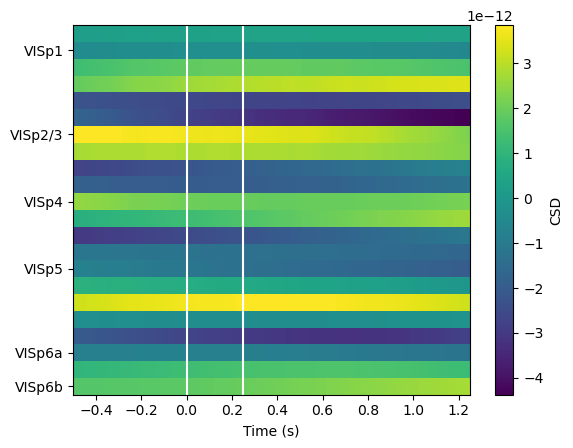

In [10]:
_, ax = plt.subplots(1, 1)

pcm = ax.pcolormesh(
    aligned_csd.time_from_presentation_onset,
    channel_positions,
    aligned_csd
)
plt.colorbar(mappable=pcm, ax=ax, label='CSD')

ax.axvline(0, color='w')
ax.axvline(flashes_duration, color='w')

ax.set_xlabel('Time (s)')
ax.set_yticks(central_channels_positions)
ax.set_yticklabels(list(central_channels))

plt.show()

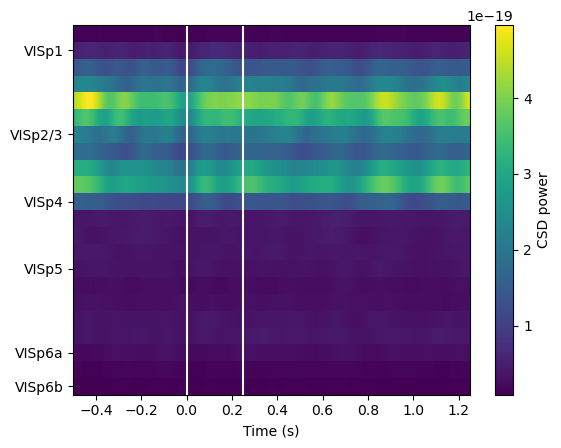

In [11]:
_, ax = plt.subplots(1, 1)

pcm = ax.pcolormesh(
    averaged_flashes_csd.time_from_presentation_onset,
    channel_positions,
    averaged_flashes_csd
)
plt.colorbar(mappable=pcm, ax=ax, label='CSD power')

ax.axvline(0, color='w')
ax.axvline(flashes_duration, color='w')

ax.set_xlabel('Time (s)')
ax.set_yticks(central_channels_positions)
ax.set_yticklabels(list(central_channels))

plt.show()

Normalized by baseline power


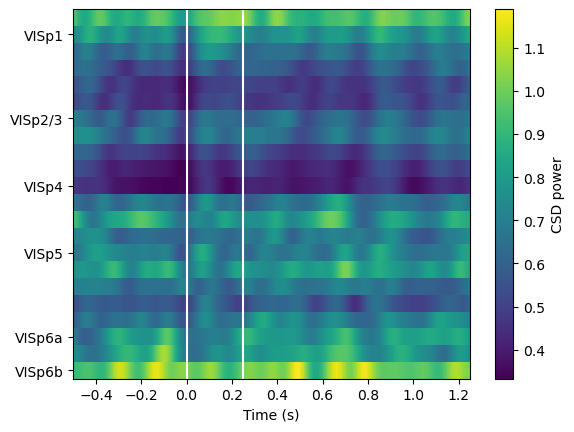

In [12]:
print("Normalized by baseline power")

_, ax = plt.subplots(1, 1)

pcm = ax.pcolormesh(
    averaged_flashes_csd.time_from_presentation_onset,
    channel_positions,
    averaged_flashes_csd / baseline_power
)
plt.colorbar(mappable=pcm, ax=ax, label='CSD power')

ax.axvline(0, color='w')
ax.axvline(flashes_duration, color='w')

ax.set_xlabel('Time (s)')
ax.set_yticks(central_channels_positions)
ax.set_yticklabels(list(central_channels))

plt.show()

In [13]:
# drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
#     stimulus_presentations, 'drifting_gratings_contrast')